# HALP with ResNet-18 on CIFAR-10

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [10]:
# Helpers 

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

def read_data(filename):
    with open(filename, "r") as f:
        acc = np.loadtxt(f)
    return acc

In [31]:
# Load csv results

# SGD run broken into 3 runs with lr decaying between runs
sgd_test_1 = read_data('sgd/ResNet_lr_0.1_test.csv')
sgd_test_2 = read_data('sgd/ResNet_lr_0.01_test.csv') 
sgd_test_3 = read_data('sgd/ResNet_lr_0.001_test.csv')
sgd_train_1 = read_data('sgd/ResNet_lr_0.1_train.csv')
sgd_train_2 = read_data('sgd/ResNet_lr_0.01_train.csv') 
sgd_train_3 = read_data('sgd/ResNet_lr_0.001_train.csv')
sgd_test = np.concatenate((sgd_test_1[:60], sgd_test_2[:9], sgd_test_3[:81]))
num_batches = 391 # number of batches in an epoch
sgd_train = np.concatenate((sgd_train_1[:60*num_batches], sgd_train_2[:9*num_batches], sgd_train_3[:81*num_batches]))

# SVRG
svrg_T165_test = read_data('svrg/ResNet_lr_0.1_T_165_l2_5e-4_test.csv')
svrg_T165_train = read_data('svrg/ResNet_lr_0.1_T_165_l2_5e-4_train.csv')
svrg_T391_test = read_data('svrg/ResNet_lr_0.1_T_391_l2_5e-4_test.csv')
svrg_T391_train = read_data('svrg/ResNet_lr_0.1_T_391_l2_5e-4_train.csv')

# HALP
halp_b2_T391_test = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_2_l2_5e-4_test.csv')
halp_b4_T391_test = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_4_l2_5e-4_test.csv')
halp_b8_T391_test = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_8_l2_5e-4_test.csv')
halp_b8_T165_test = read_data('halp/ResNet_lr_0.1_T165_mu_20.0_b_8_l2_5e-4_test.csv')
halp_b8_T1173_test = read_data('halp/ResNet_lr_0.1_T1173_mu_20.0_b_8_l2_5e-4_test.csv')
halp_b2_T391_train = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_2_l2_5e-4_train.csv')
halp_b4_T391_train = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_4_l2_5e-4_train.csv')
halp_b8_T391_train = read_data('halp/ResNet_lr_0.1_T391_mu_20.0_b_8_l2_5e-4_train.csv')
halp_b8_T165_train = read_data('halp/ResNet_lr_0.1_T165_mu_20.0_b_8_l2_5e-4_train.csv')
halp_b8_T1173_train = read_data('halp/ResNet_lr_0.1_T1173_mu_20.0_b_8_l2_5e-4_train.csv')

## SGD v. SVRG v. HALP

Below, we compare the performance of full-precision SGD, full-precision SVRG, and 8-bit HALP.

Optimizer | Hyperparameters
--- | :---:
SGD | lr = 0.1 epochs [0,60), lr = 0.01 [60,69), lr = 0.001 [69, 150), momentum = 0.9, l2_reg = 0.0005
SVRG | lr = 0.1, T = 0.5N, l2_reg = 0.0005
HALP | lr = 0.1, T = 0.5N, b = 8, mu = 20, l2_reg = 0.0005

For the SGD shown, we used a decaying learning rate. To determine the decay rate, we ran SGD with lr 0.1 for 150 epochs, then 0.01 for 100 epochs, then 0.001 for 150 epochs, resuming from the epoch and model with the best validation accuracy within each of those intervals. The decaying learning rate contributes to the drop we see in validation accuracy on the edge of an interval. The learning rate was held constant for SVRG and HALP.

<IPython.core.display.Javascript object>


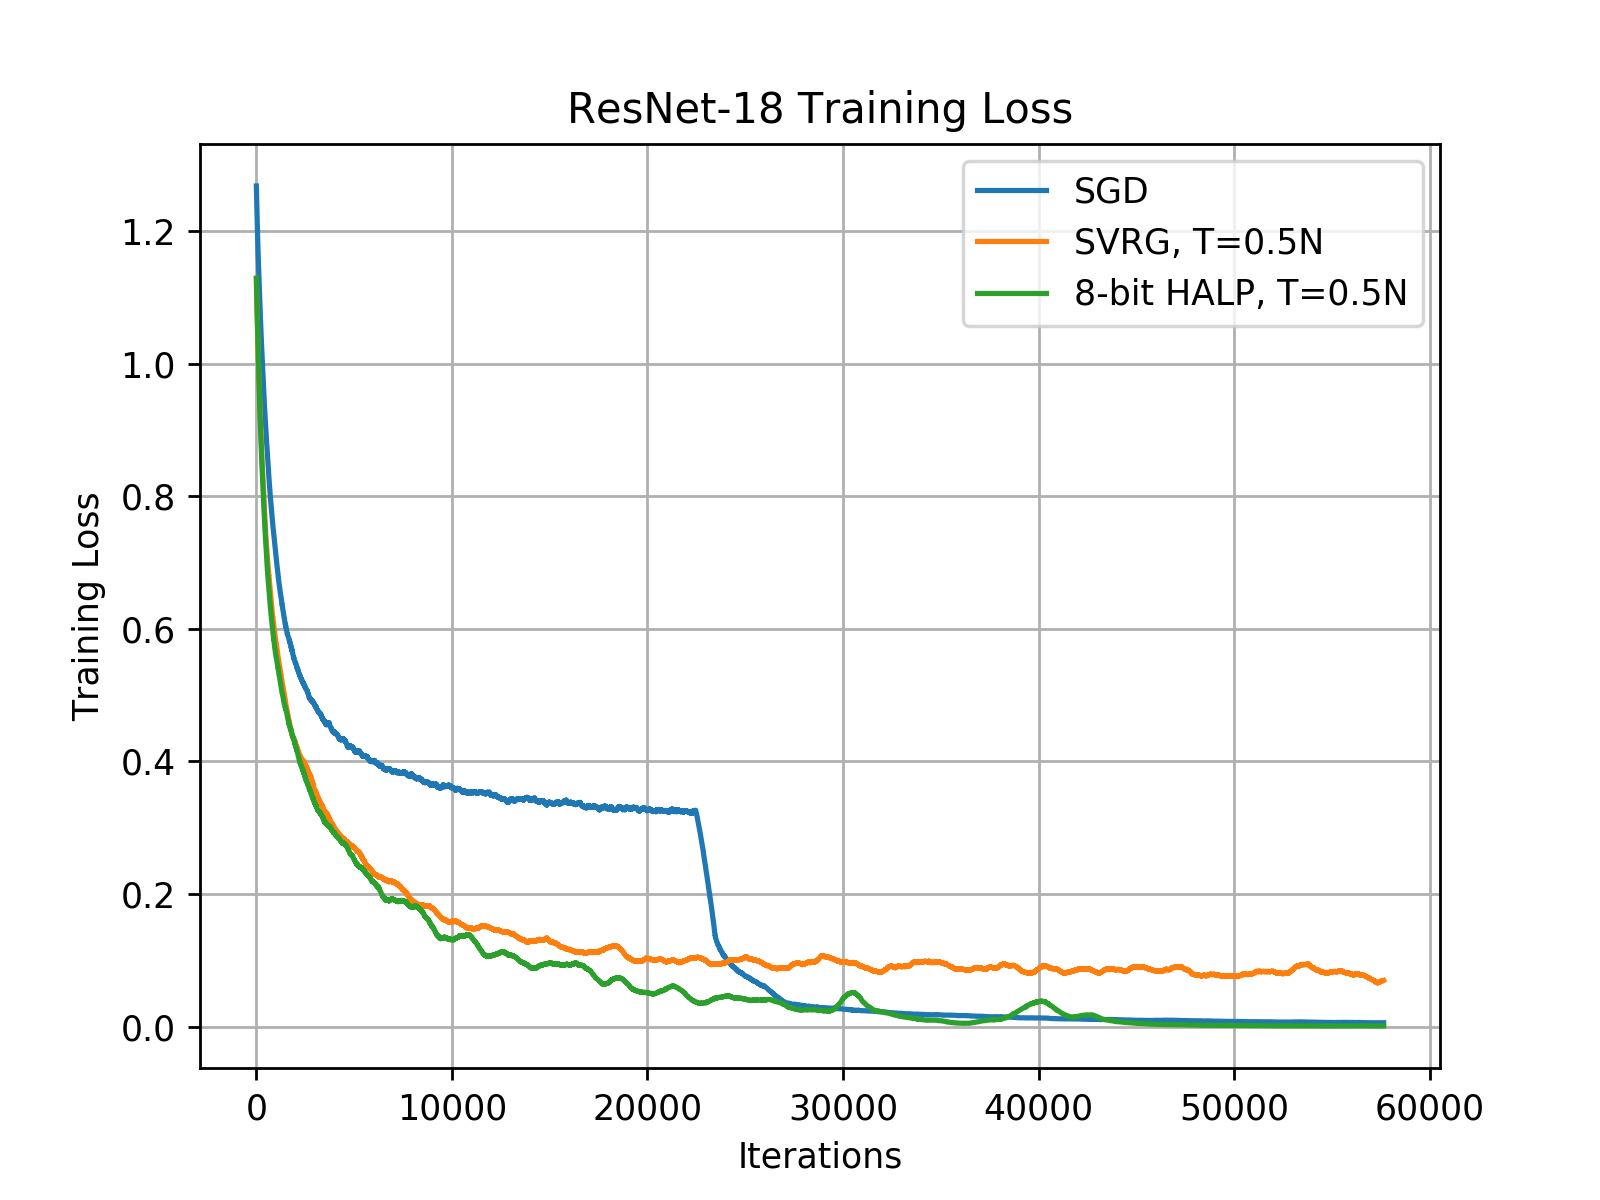

<IPython.core.display.Javascript object>


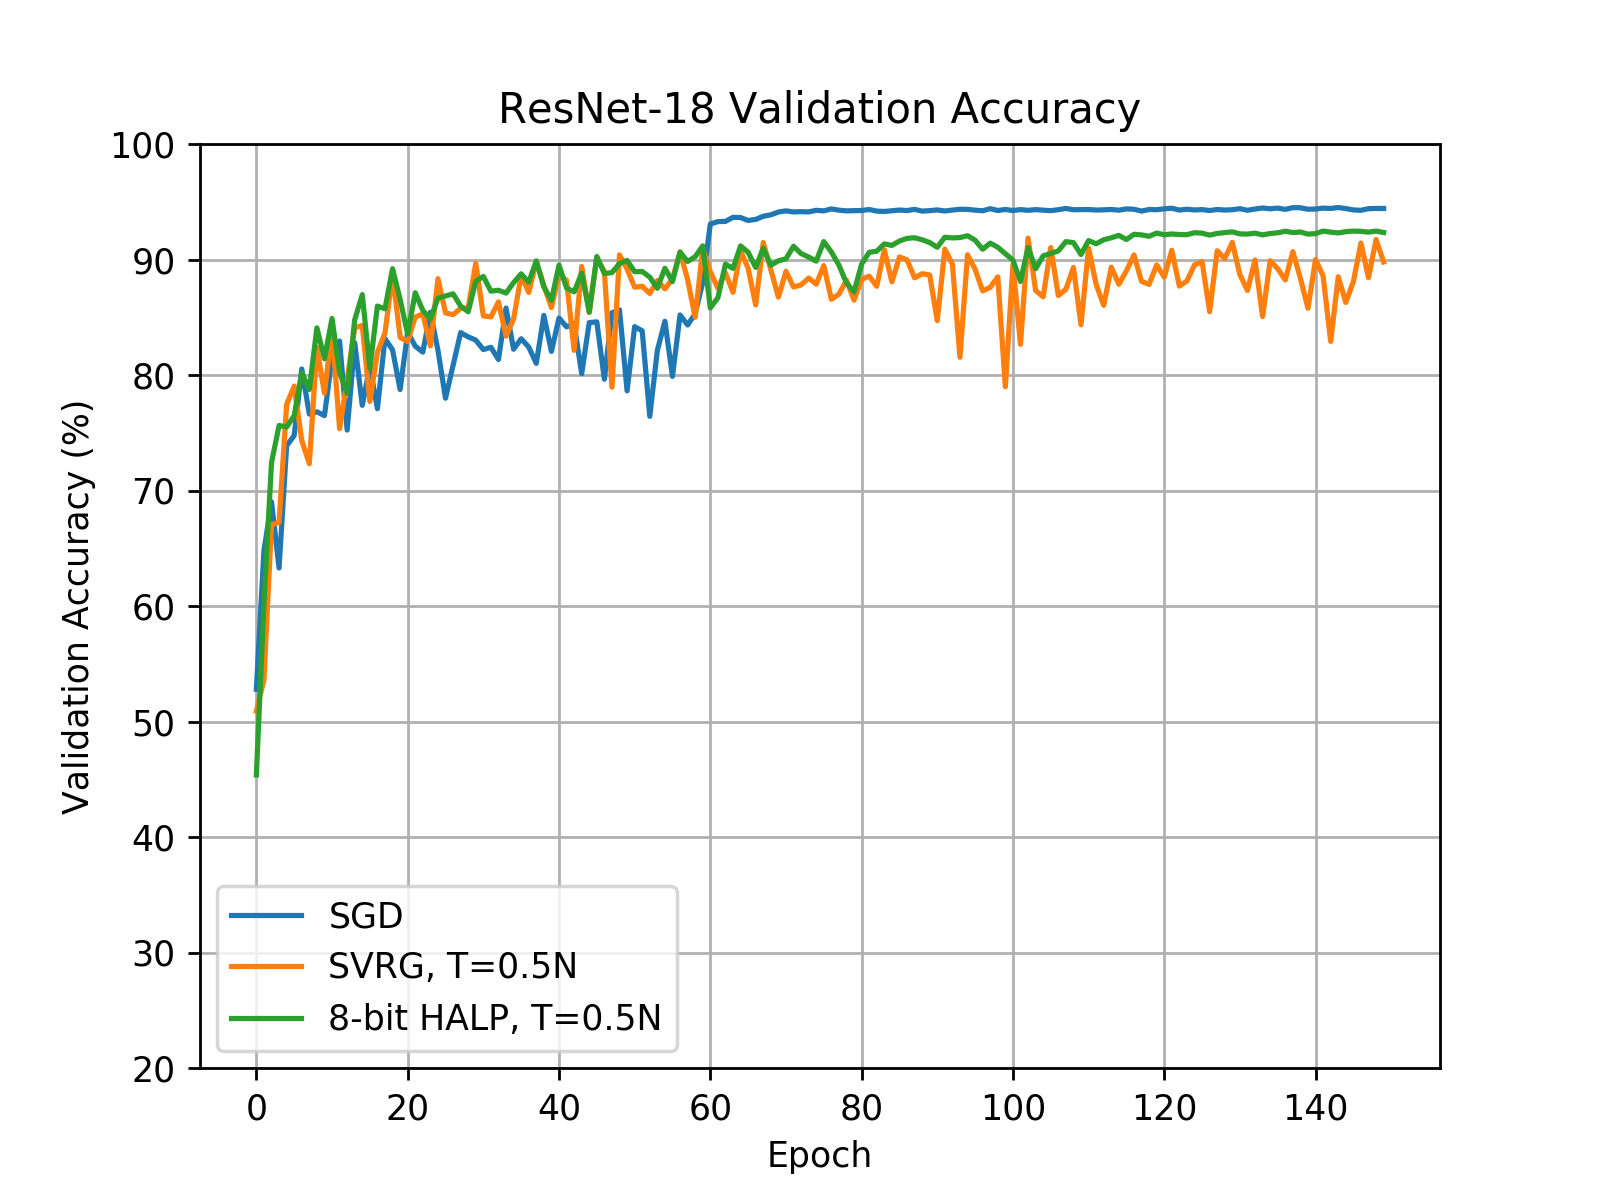

In [33]:
plt.figure()
plt.plot(running_mean(sgd_train, 1000), label="SGD")
plt.plot(running_mean(svrg_T165_train, 1000), label="SVRG, T=0.5N")
plt.plot(running_mean(halp_b8_T165_train, 1000), label="8-bit HALP, T=0.5N")
plt.grid()
plt.title("ResNet-18 Training Loss")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

plt.figure()
plt.plot(sgd_test, label="SGD")
plt.plot(svrg_T165_test, label="SVRG, T=0.5N")
plt.plot(halp_b8_T165_test, label="8-bit HALP, T=0.5N")
plt.grid()
plt.ylim([20, 100])
plt.title("ResNet-18 Validation Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()

# HALP Experiments

## Sweep Hyperparameter T

We sweep T for 8-bit HALP (meaning 8-bits are used to store the offset $z$ from the model). We see a slight decrease in validation accuracy as we increase T, from being half an epoch to being 3 epochs. When T=1N, this means we take the full gradient and do the bit centering step after one full pass of batch updates over the dataset. When T=3N, we take the full gradient and do the bit centering after every 3 passes over the dataset, which is more computationally efficient but results in a degraded accuracy.

<IPython.core.display.Javascript object>


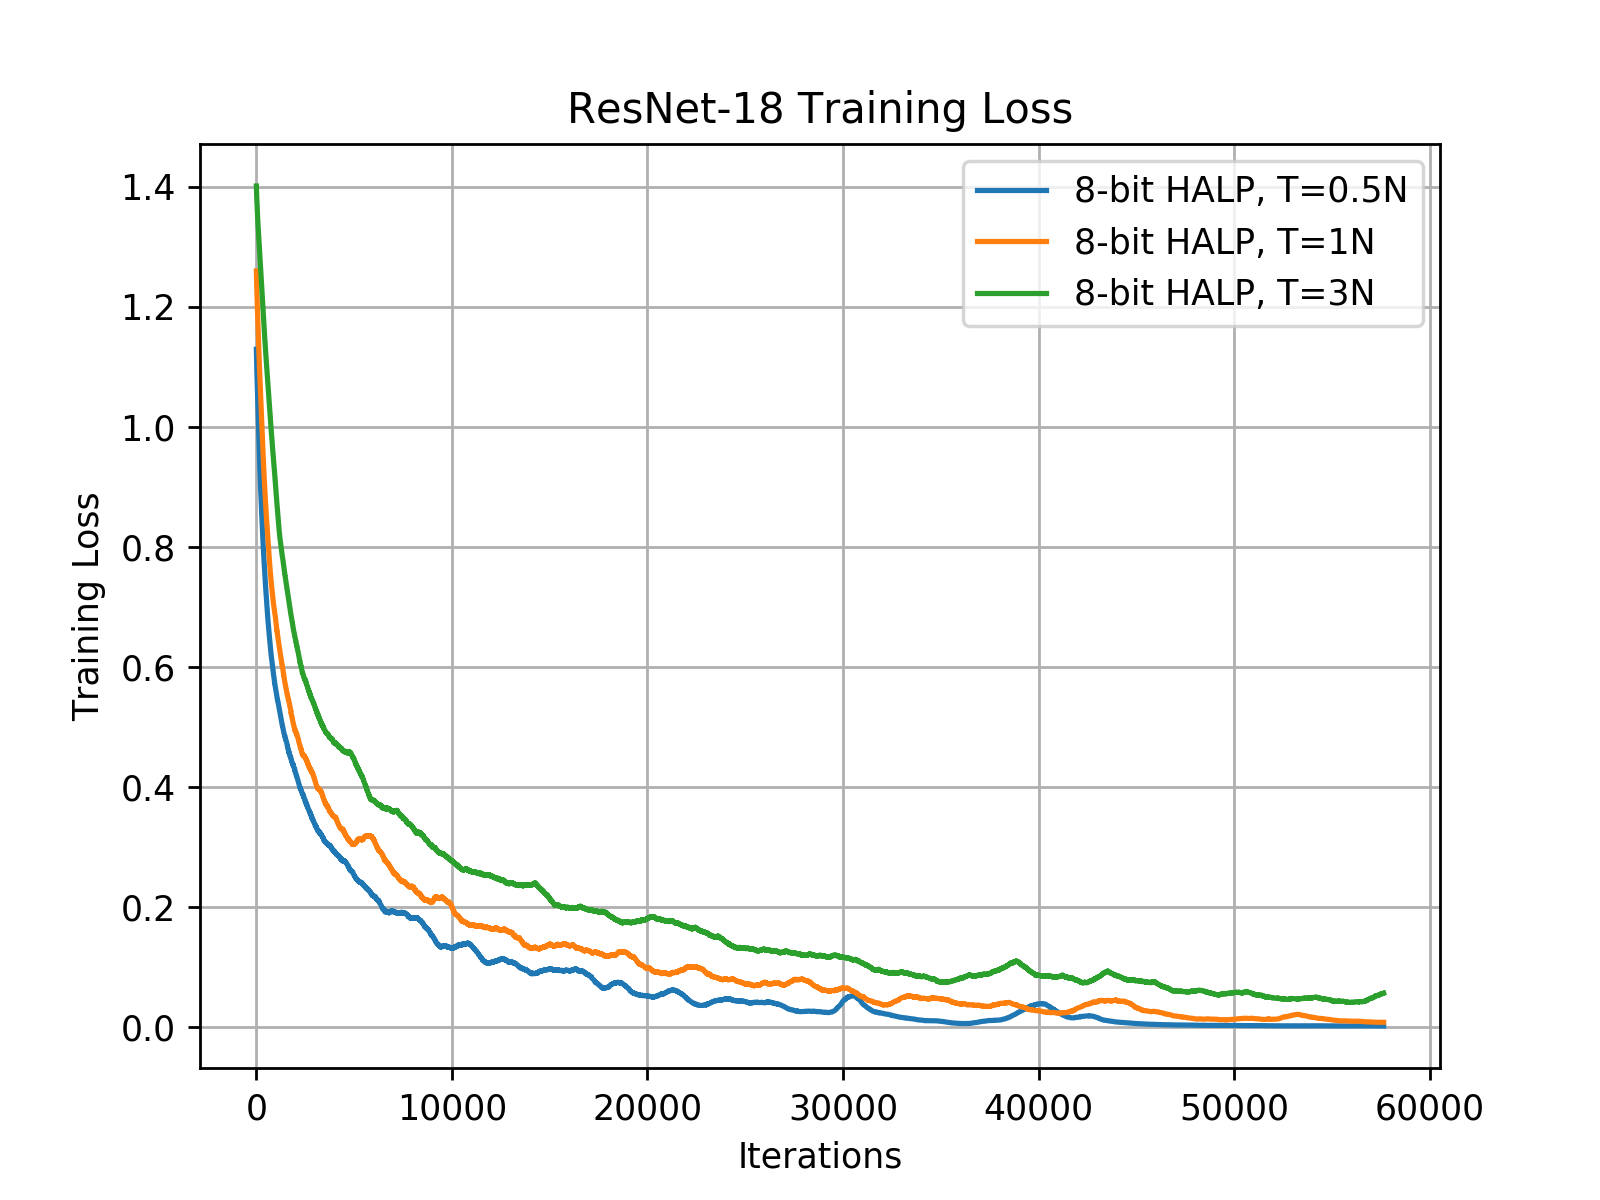

<IPython.core.display.Javascript object>


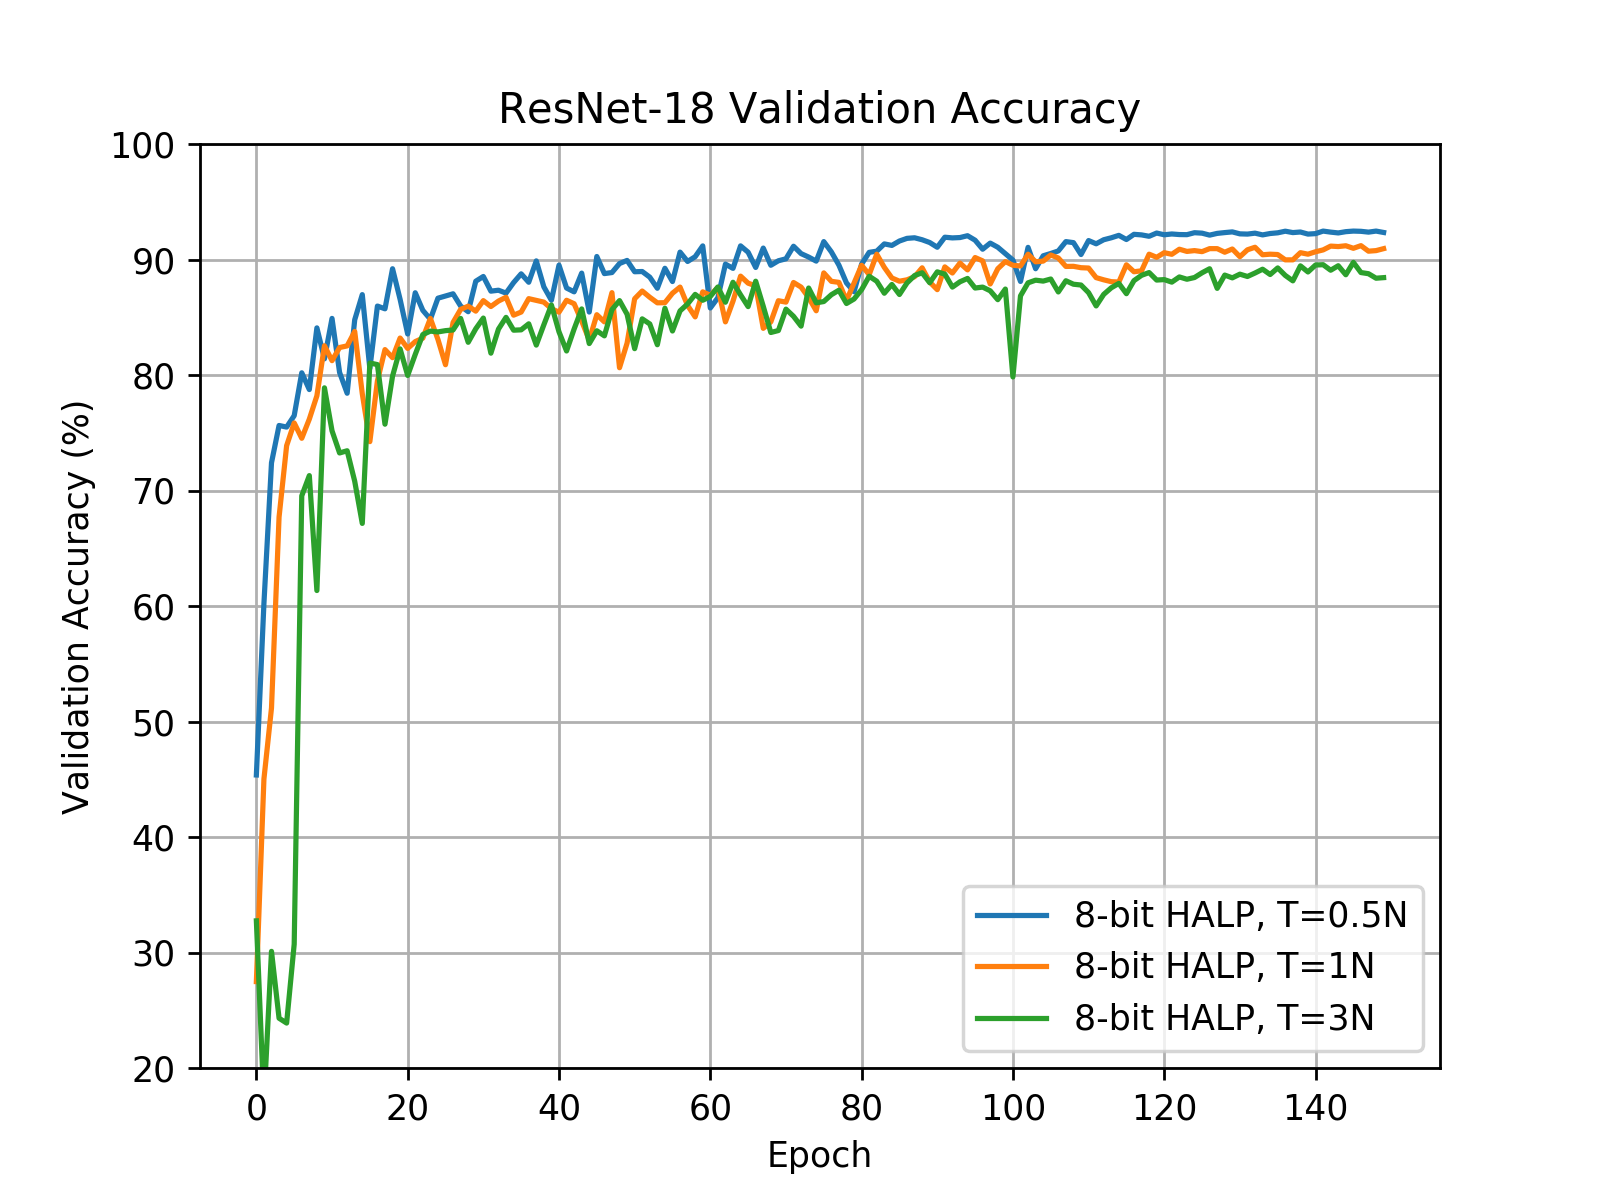

In [34]:
plt.figure()
plt.plot(running_mean(halp_b8_T165_train, 1000), label="8-bit HALP, T=0.5N")
plt.plot(running_mean(halp_b8_T391_train, 1000), label="8-bit HALP, T=1N")
plt.plot(running_mean(halp_b8_T1173_train, 1000), label="8-bit HALP, T=3N")
plt.grid()
plt.title("ResNet-18 Training Loss")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

plt.figure()
plt.plot(halp_b8_T165_test, label="8-bit HALP, T=0.5N")
plt.plot(halp_b8_T391_test, label="8-bit HALP, T=1N")
plt.plot(halp_b8_T1173_test, label="8-bit HALP, T=3N")
plt.grid()
plt.ylim([20, 100])
plt.title("ResNet-18 Validation Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()

## Sweep Number of Bits 
Then we sweep the number of bits used for the model offset, holding T=1N and maintaining the same hyperparameter settings for l2-regularization and learning rate as before. We are able to recover comparable test performance with 4-bit and 8-bit HALP, but see a significant performance degradation with 2-bit HALP. 

<IPython.core.display.Javascript object>


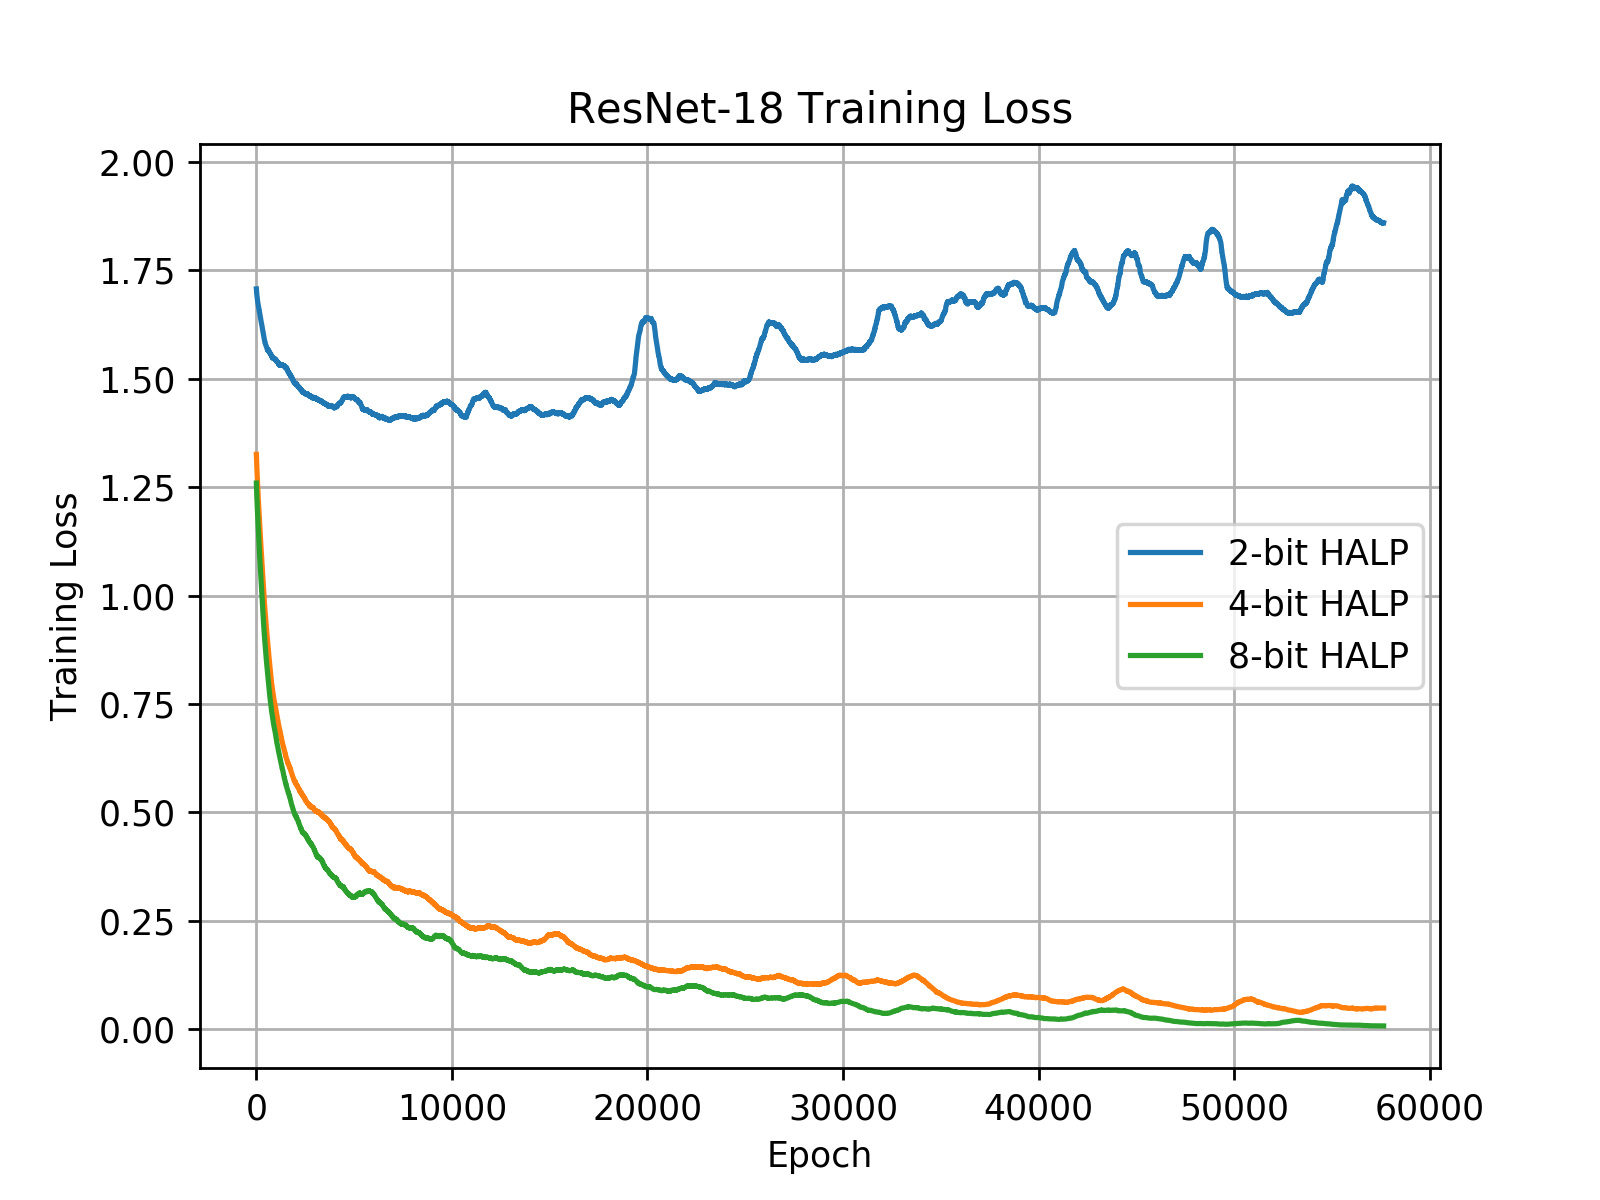

<IPython.core.display.Javascript object>


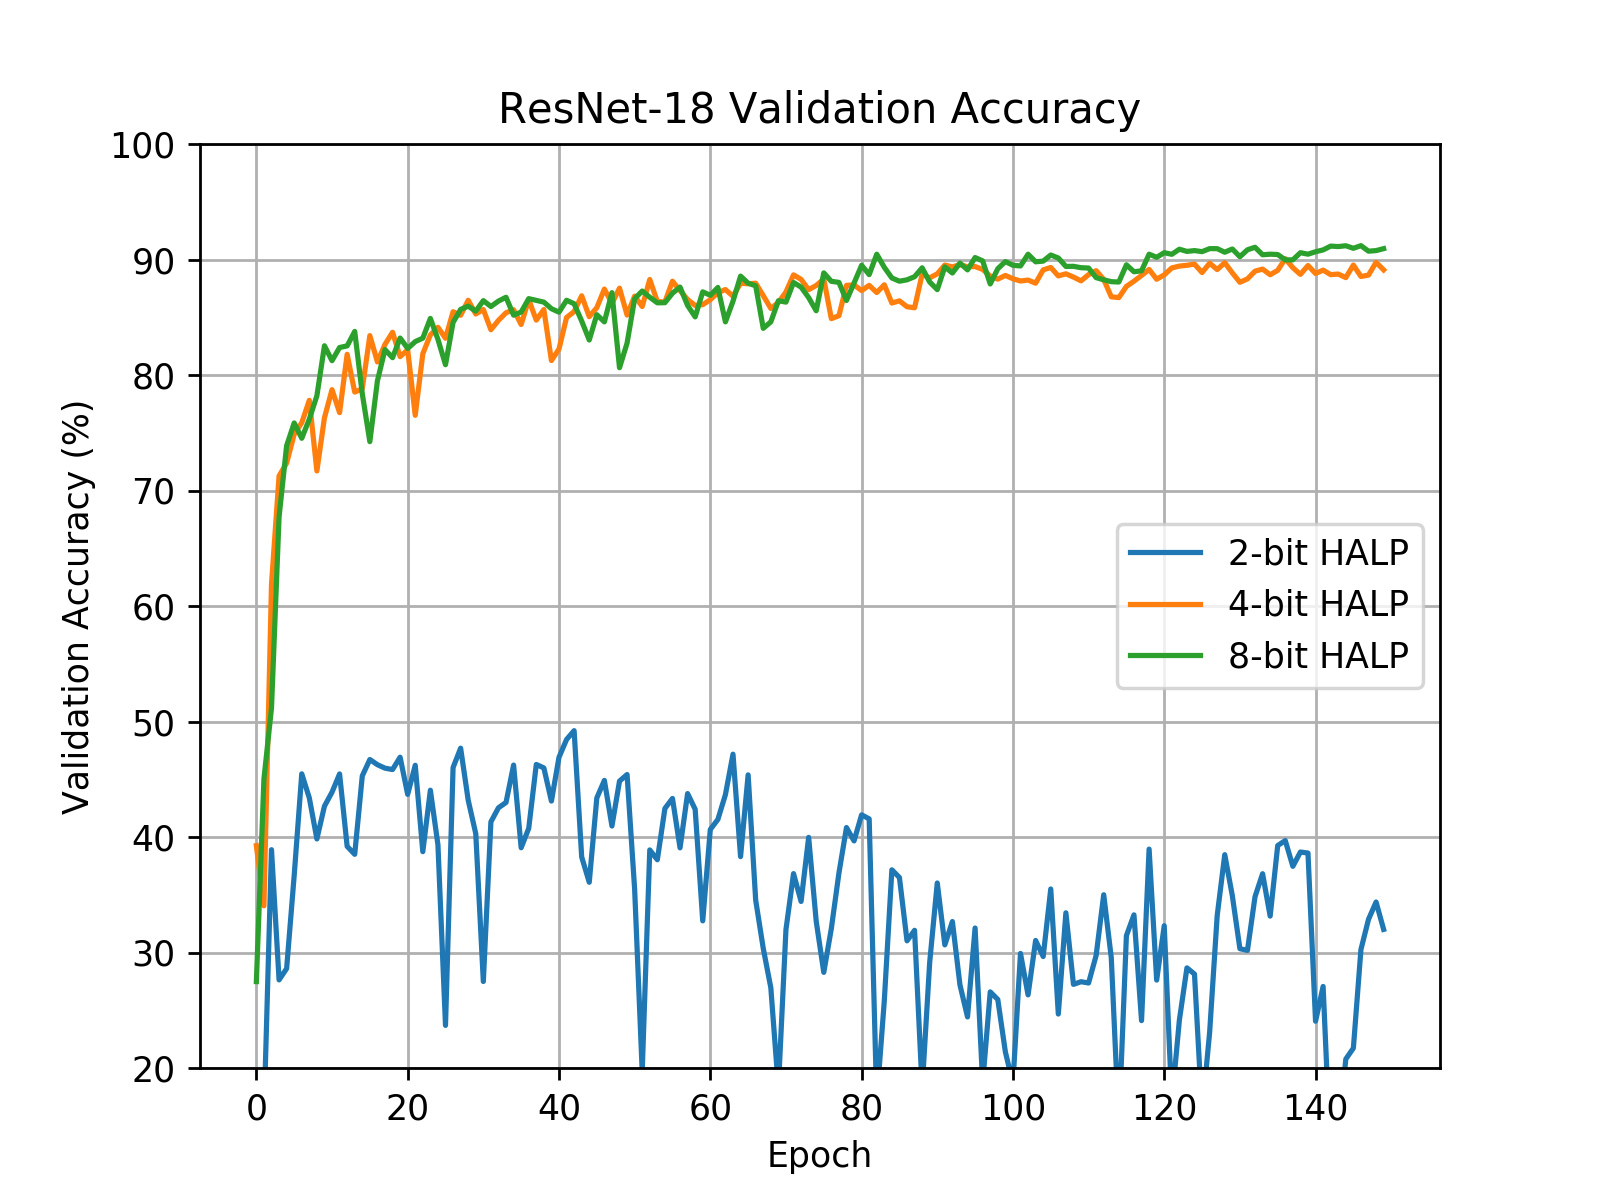

In [35]:
plt.figure()
plt.plot(running_mean(halp_b2_T391_train, 1000), label="2-bit HALP")
plt.plot(running_mean(halp_b4_T391_train, 1000), label="4-bit HALP")
plt.plot(running_mean(halp_b8_T391_train, 1000), label="8-bit HALP")
plt.grid()
plt.title("ResNet-18 Training Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

plt.figure()
plt.plot(halp_b2_T391_test, label="2-bit HALP")
plt.plot(halp_b4_T391_test, label="4-bit HALP")
plt.plot(halp_b8_T391_test, label="8-bit HALP")
plt.grid()
plt.ylim([20, 100])
plt.title("ResNet-18 Validation Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()